# Imports

In [1]:
from XRDXRFutils import (Phase, DatabaseXRD, DataXRF, DataXRD, SpectraXRD, FastSpectraXRD, GaussNewton,
    PhaseList, ChiSearch, GammaMap, ChiMap, Phase, PhaseList, GammaSearch_Secondary, GammaMap_Secondary)

from os.path import isdir
from os import makedirs
from shutil import rmtree

import h5py
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit, least_squares

from numpy import (linspace, concatenate, sqrt, log, sin, cos, pi, histogram, array, unravel_index, savetxt,
    isnan, flip, sum, average, amax, nanmax, nanmin, nanmean, arange, empty, newaxis, stack, clip,
    quantile, ones, zeros, absolute)
import pandas as pd

from matplotlib.pyplot import (sca, show, fill_between, legend, imshow, subplots, plot, xlim, ylim,
    xlabel, ylabel, cm, title, scatter, colorbar, figure, vlines, savefig, get_cmap, hist)
from matplotlib import rcParams
from matplotlib.ticker import FuncFormatter, ScalarFormatter
from matplotlib.markers import MarkerStyle
from matplotlib.colors import BoundaryNorm
from matplotlib.lines import Line2D
from matplotlib.cm import get_cmap

from sklearn.cluster import KMeans, MiniBatchKMeans

from multiprocessing import Pool

from glob import glob
from PIL import Image

from pathlib import Path


def z_from_s(s):
    angle_picture_detector = 90 + angle_incidence - data.opt[2]
    z = s / cos(angle_picture_detector * pi / 180)
    return z * channel_distance


def f_linear(x,a,b):
    return a*x + b


def f_loss(x,t,y):
    return (x[0]*t + x[1]) - y


def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)


def read_raw_XRD(path_xrd, filename_scanning = 'Scanning_Parameters.txt', filename_calibration = 'calibration.ini', filename_h5 = 'xrd.h5'):
    return (DataXRD().read_params(path_xrd + filename_scanning).read(path_xrd)
            .calibrate_from_file(path_xrd + filename_calibration).remove_background().save_h5(path_xrd + filename_h5))


def correct_point(experimental_phases, idx_phase, gm, x, y):
    gn = gm.get_pixel(x, y)[idx_phase]
    phase = gn.make_phase()
    phase.set_name('created_%d'%idx_phase)
    phase.set_point(gm.get_index(x, y))
    experimental_phases[idx_phase] = phase

    
def rename_phase_in_database(database, name_old, name_new):
    for p in database[name_old]:
        p['_chemical_name_mineral'] = name_new
    database[name_new] = database[name_old]
    del database[name_old]


def find_element(element, labels, allow_loose = True):
    for j, label in enumerate(labels):
        if (element + '_') in label:   # search for the given string + '_' in XRF label
            return j
    if allow_loose:
        for j, label in enumerate(labels):
            if element in label:   # search for the given string in XRF label
                return j
    return None


def settings_lims(ax, x_min, x_max, y_min, y_max):
    if (x_min is not None):
        x_min -= 0.5
    if (x_max is not None):
        x_max += 0.5
    if (y_min is not None):
        y_min -= 0.5
    if (y_max is not None):
        y_max += 0.5
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)


def settings_plot(im, ax, x_min, x_max, y_min, y_max, position_colorbar, label_colorbar = None, powerlimits = None):
    settings_lims(ax, x_min, x_max, y_min, y_max)
    if (powerlimits is not None):
        formatter = ScalarFormatter(useMathText = True)
        formatter.set_scientific(True)
        formatter.set_powerlimits(powerlimits)
        cb = colorbar(im, ax = ax, cax = ax.inset_axes(position_colorbar), format = formatter)
        cb.ax.yaxis.set_offset_position('left')
    else:
        cb = colorbar(im, ax = ax, cax = ax.inset_axes(position_colorbar))
    if (label_colorbar is not None):
        cb.set_label(label_colorbar)


rcParams.update({
'image.origin': 'lower'
})

# Define paths and parameters

In [2]:
#path_shared = '/home/shared/'
path_shared = '../../shared/'

### Input ###
path_scan = path_shared + 'dataXRDXRF/MunchMuseum/M491/'
path_xrd = path_scan + 'ProfiloXRD/'          # XRD scan 
path_xrf = path_scan + 'ProfiloXRF/labels/'   # XRF scan
path_photo = path_scan + 'ProfiloFoto/'       # photo of the scanned section
path_zmap = path_shared + 'VenereBZPosition/'
path_database = path_shared + 'Database/'     # tabulated phases

### Output ###
subfolder_output = 'MunchMuseum/M491/Profilo/'
path_figures = 'figures/' + subfolder_output          # figures generated by the script
path_results = 'results/' + subfolder_output          # results generated by the script: raw data, tif maps
path_database_exp = 'databaseEXP/' + subfolder_output # experimental phases

### Parameters ###
min_theta = 20
max_theta = 53
min_intensity = 0.1  # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = None # selects the first n most intense peaks (if None, leaves all the peaks)
sigma = 0.2          # sigma used in the peaks of synthetic diffraction patterns

#### To reset results, delete output folders.
WARNING: every previous result will be lost. Use only if you want to delete all files in the data folders

In [3]:
do_you_want_to_delete = False

if do_you_want_to_delete:
    if isdir(path_figures):
        rmtree(path_figures)
    if isdir(path_results):
        rmtree(path_results)
    if isdir(path_database_exp):
        rmtree(path_database_exp)

#### Check if output folders exist. If not, create them.

In [4]:
if not isdir(path_figures):
    makedirs(path_figures)
if not isdir(path_results):
    makedirs(path_results)
if not isdir(path_database_exp):
    makedirs(path_database_exp)

# Show photo of scanned section

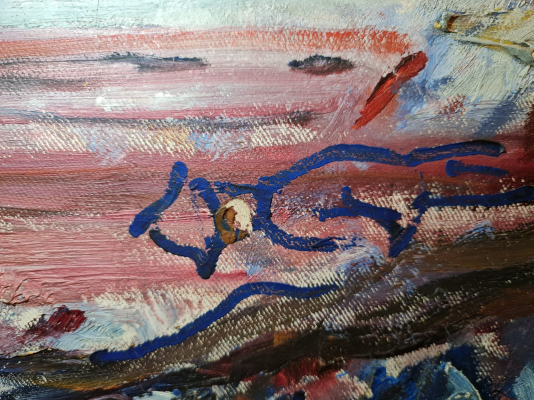

In [5]:
filenames = glob(path_photo + '*.jpg')
for filename in filenames:
    im = Image.open(filename)
    display(im.reduce(3))

# Read XRD Data and Database
To recalculate h5 file, change just for one time the filename that the cell tries to read (indicated by the comment)

In [6]:
%matplotlib inline
rcParams['font.size'] = 12

try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5') # to force the recalculation of h5 file, change this filename
    if any(not hasattr(data, attr) for attr in data.check_attributes):
        print('The present h5 file doesn\'t have all required information. Reading from raw data.')
        data = read_raw_XRD(path_xrd)
except:
    print('Reading from raw data.')
    data = read_raw_XRD(path_xrd)
    
print(f'Shape of data: {data.shape}')
print('Initial calibration:')
print(f'a = {data.opt[0]:.1f}, s = {data.opt[1]:.1f}, beta = {data.opt[2]:.3f}')
print(f'Theta range {list(data.fce_calibration([0, data.shape[2]], *data.opt))}')

database = DatabaseXRD().read_cifs(path_database)
print('\nPhases in database:', len(database))

Loading: ../../shared/dataXRDXRF/MunchMuseum/M491/ProfiloXRD/xrd.h5
Shape of data: (95, 170, 1280)
Initial calibration:
a = -1214.7, s = 1952.7, beta = 51.663
Theta range [19.77907407899562, 53.578190550653794]

Phases in database: 367


# Burnt pixels

### Show them
Choose a quantile on the value of maximum channel. All pixels above that quantile will be considered burnt pixel.

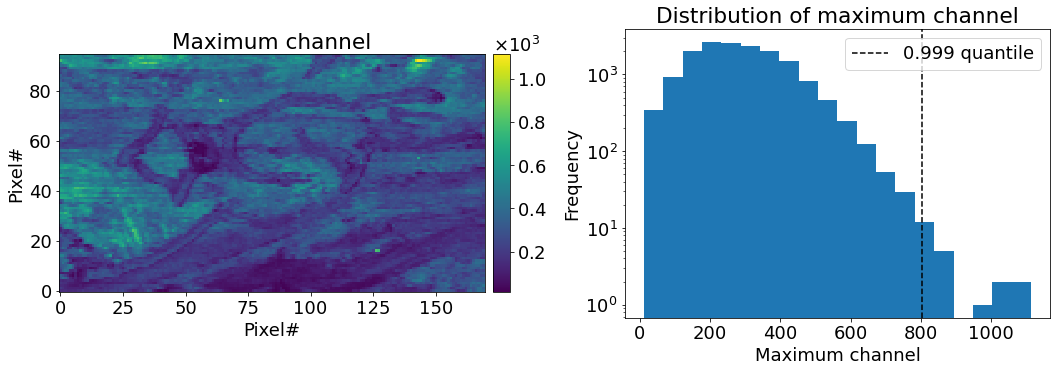

17 pixels out of 16150 are selected as burnt.


In [7]:
rcParams['font.size'] = 18

qtl = 0.999
#qtl = 1

data_max = (data.data - data.background).max(axis = 2)
indices_to_correct = data_max > quantile(data_max, qtl)

fig, axs = subplots(1, 2, figsize = (15, 5))
fig.tight_layout(w_pad = 5)

ax = axs[0]
data_to_process = data.data - data.background
im = ax.imshow(data_max, interpolation = 'none')
formatter = ScalarFormatter(useMathText = True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 3))
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]), format = formatter)
cbar.ax.yaxis.set_offset_position('left')
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')
ax.set_title('Maximum channel')

ax = axs[1]
ax.hist(data_max.flatten(), bins = 'doane') # 'sqrt'
ax.axvline(quantile(data_max, qtl), c = 'black', ls = '--', label = f'{qtl} quantile')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Maximum channel')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of maximum channel')

show()
print(f'{indices_to_correct.sum()} pixels out of {data.shape[0] * data.shape[1]} are selected as burnt.')

### Correct them
Substitute burnt pixel with the average of the non burnt ones.

In [8]:
data.data[indices_to_correct] = data.data[~indices_to_correct].mean(axis = 0, keepdims = True)
data.background[indices_to_correct] = data.background[~indices_to_correct].mean(axis = 0, keepdims = True)
data.intensity[indices_to_correct] = data.intensity[~indices_to_correct].mean(axis = 0, keepdims = True)
data.signal_background_ratio[indices_to_correct] = data.signal_background_ratio[~indices_to_correct].mean(axis = 0, keepdims = True)
data.rescaling[indices_to_correct] = data.rescaling[~indices_to_correct].mean(axis = 0, keepdims = True)

print(f'{indices_to_correct.sum()} pixels out of {data.shape[0] * data.shape[1]} were corrected.')

17 pixels out of 16150 were corrected.


# Show aggregated information about XRD data

We process raw XRD data by subtracting the background (obtained by SNIP).
On this data we calculate aggregated information.

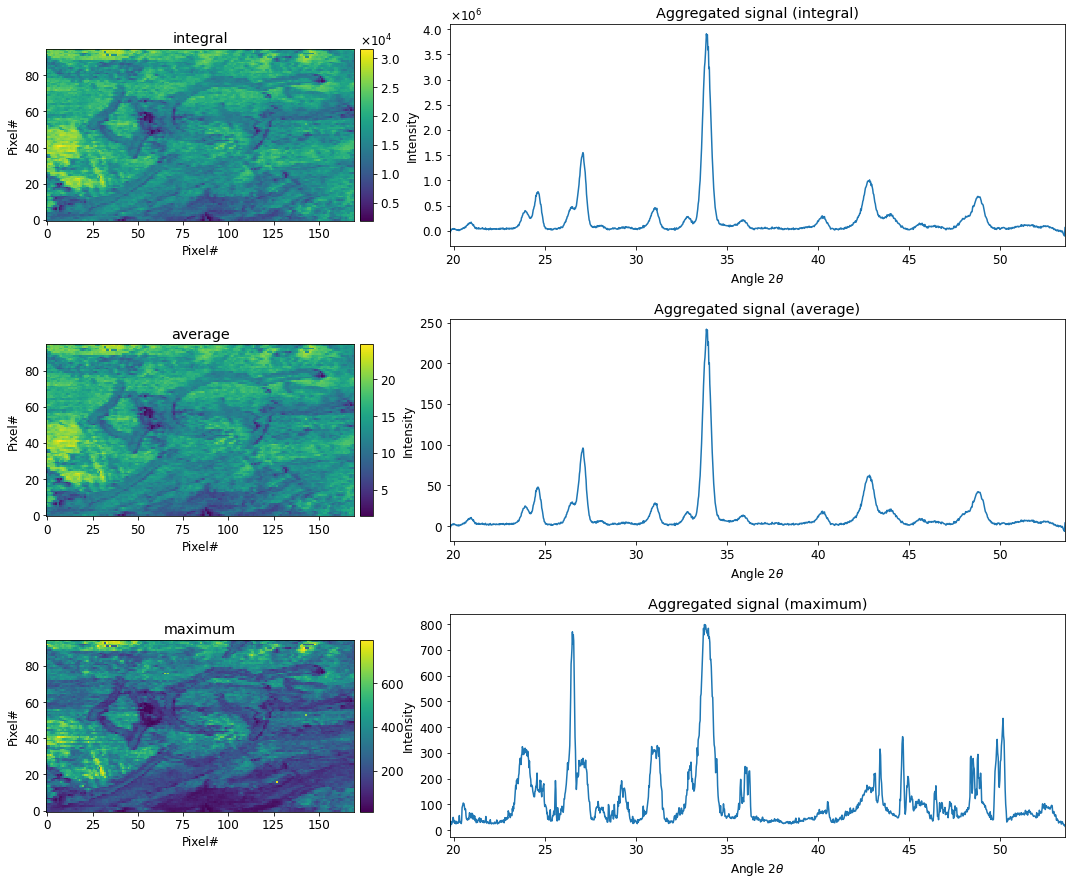

In [9]:
rcParams['font.size'] = 12

fig, axs = subplots(3, 2, figsize = (15, 12), gridspec_kw = {'width_ratios': [1, 2]})
fig.tight_layout(h_pad = 4, w_pad = 5)

theta = data.fce_calibration(range(data.shape[-1]), *data.opt)
list_aggregations = ['integral', 'average', 'maximum']
list_functions = [sum, average, amax]
data_to_process = data.data - data.background

for i in range(len(list_aggregations)):
    
    image_aggregated = list_functions[i](data_to_process, axis = 2)
    ax = axs[i, 0]
    im = ax.imshow(image_aggregated, interpolation = 'none')
    formatter = ScalarFormatter(useMathText = True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 3))
    cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.02,0, 0.04, 1]), format = formatter)
    cb.ax.yaxis.set_offset_position('left')
    ax.set_title(list_aggregations[i])
    ax.set_ylabel(r'Pixel#')
    ax.set_xlabel(r'Pixel#')
    
    xrdpattern_aggregated = list_functions[i](data_to_process, axis = (0, 1))
    ax = axs[i, 1]
    ax.plot(theta, xrdpattern_aggregated)
    ax.ticklabel_format(useMathText = True)
    ax.set_xlim(theta[0], theta[-1])
    ax.set_xlabel(r'Angle $2\theta$')
    ax.set_ylabel('Intensity')
    ax.set_title(f'Aggregated signal ({list_aggregations[i]})')

savefig(f'{path_figures}aggregated_info.png', bbox_inches = 'tight', dpi = 300)
show()

# Rescaling and signal / background ratio

- 'Rescaling' shows, for each pixel, the maximum value of the experimental diffraction pattern after we subtract the background.
This value is used to obtain the rescaled signal in the interval [0, 1].
That's why we indicate this value as 'rescaling'.

- 'Signal/Noise' indicates the integral of the experimental diffraction pattern divided by the integral of the background.

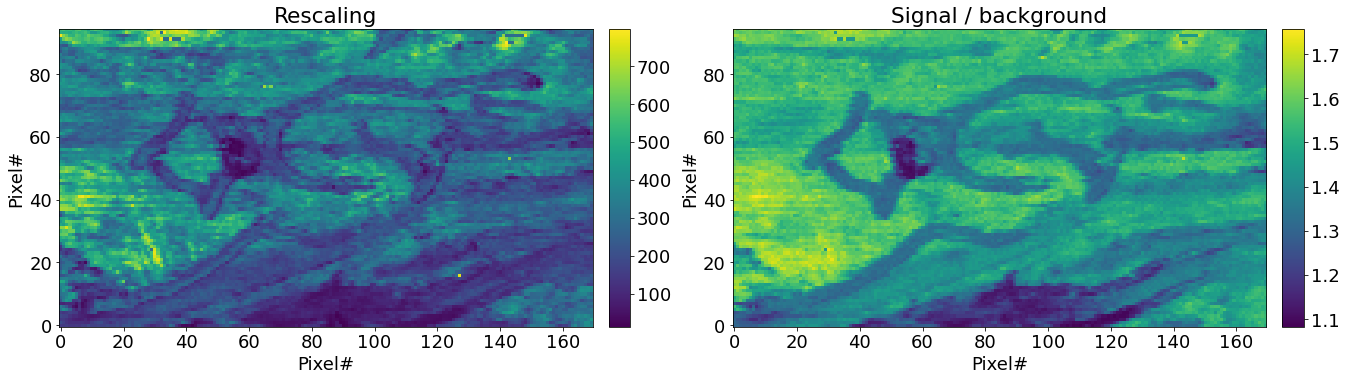

In [10]:
rcParams['font.size'] = 18

fig, axs = subplots(1, 2, figsize = (18, 6))
fig.tight_layout(w_pad = 5)

ax = axs[0]
im = ax.imshow(data.rescaling.squeeze(), interpolation = 'none')
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
ax.set_title('Rescaling')
ax.set_ylabel(r'Pixel#')
ax.set_xlabel(r'Pixel#')

ax = axs[1]
im = ax.imshow(data.signal_background_ratio.squeeze(), interpolation = 'none')
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
ax.set_title('Signal / background')
ax.set_ylabel(r'Pixel#')
ax.set_xlabel(r'Pixel#')

show()

# Read XRF maps

If the orientation of tiff images does not correspond with XRD scans, flip them in this cell

In [11]:
data_xrf = DataXRF()
data_xrf.read_tiff(path_xrf)
data_xrf.labels = flip(data_xrf.labels, axis = [1]) # choose the axes to flip
print(f'Found {data_xrf.labels.shape[2]} images')

Found 24 images


### Correct burnt pixels in each XRF map
Choose a quantile on the value of XRF intensity. All pixels above that quantile will be corrected as burnt pixels and will be assigned the threshold value.

In [12]:
qtl = 0.999
#qtl = 1

qtl_calculated = quantile(data_xrf.labels, qtl, axis = (0, 1))[newaxis, newaxis, :]
n_corrected = (data_xrf.labels > qtl_calculated).sum() / data_xrf.labels.shape[-1]
data_xrf.labels = clip(data_xrf.labels, None, qtl_calculated)
print(f'{n_corrected:.0f} pixels out of {data_xrf.labels.shape[0] * data_xrf.labels.shape[1]} were corrected on average in each XRF map.')

17 pixels out of 16150 were corrected on average in each XRF map.


### Show XRF maps

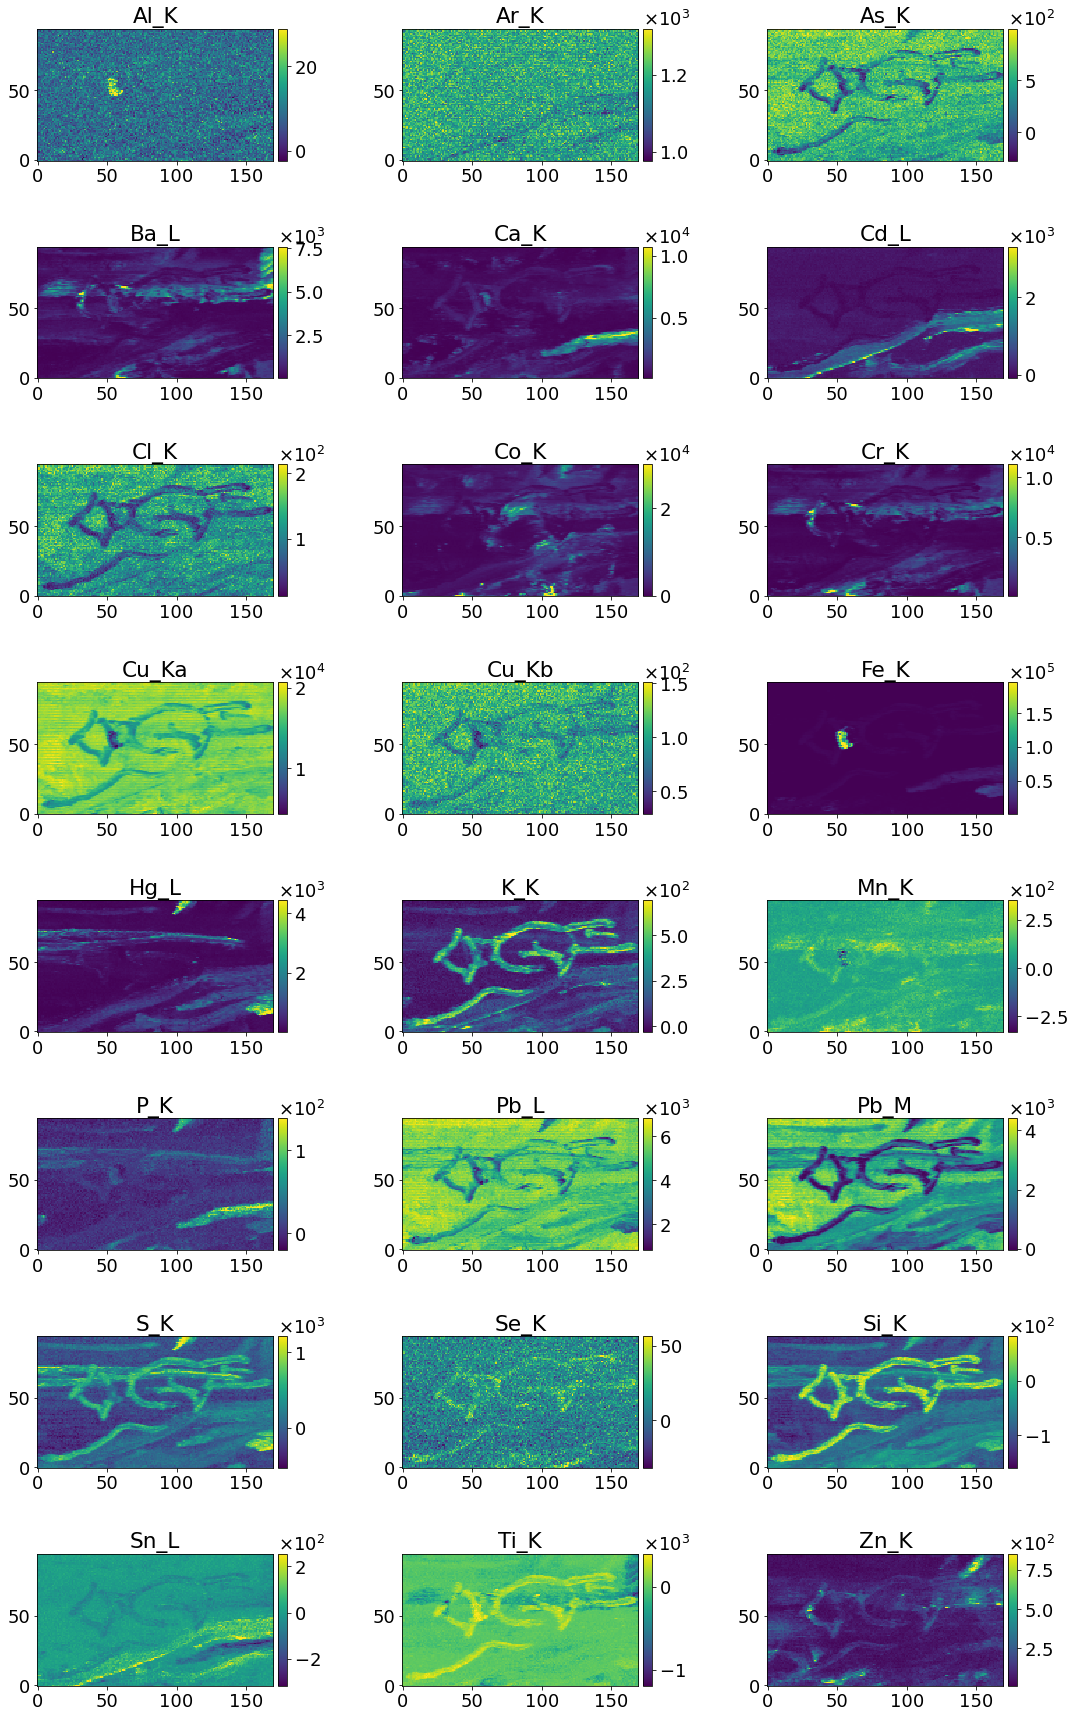

In [13]:
#%matplotlib qt
%matplotlib inline
n_of_columns = 3
rcParams['font.size'] = 18

n_of_pictures = len(data_xrf.metadata['labels'])
n_of_rows = n_of_pictures // n_of_columns
if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, axs = subplots(n_of_rows, n_of_columns, figsize = (5 * n_of_columns, 3 * n_of_rows))
fig.tight_layout(h_pad = 3, w_pad = 3)
for i, label in enumerate(data_xrf.metadata['labels']):
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    if n_of_rows == 1:
        ax = axs[i_column]
    else:
        ax = axs[i_row, i_column]
    im = ax.imshow(data_xrf.labels[..., i], interpolation = 'none')
    formatter = ScalarFormatter(useMathText = True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 2))
    cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]), format = formatter)
    cb.ax.yaxis.set_offset_position('left')
    ax.set_title(label)
show()

# Define phases

This is for simplification. Phases can be selected iteratively from database using 'Tab'

In [14]:
#rename_phase_in_database(database, 'Pb2 Sn O4', 'Lead-tin yellow')

In [15]:
hydrocerussite = database['Hydrocerussite'][0]
hydrocerussite['associated elements'] = ['Pb']

lazurite = database['Lazurite'][0]
lazurite['associated elements'] = ['Si']

cinnabar = database['Cinnabar'][1]
cinnabar['associated elements'] = ['Hg', 'S']

### Explore phase database

See the phases in the database that contain all of the chosen elements.

In [16]:
elements_chosen = ['Cd', 'Zn']

list_name = []
list_formula = []
list_number = []
for k, v in sorted(database.items()):
    p = v[0]
    if '_chemical_formula_sum' in p:
        if all(e in p['_chemical_formula_sum'] for e in elements_chosen):
            list_name.append(k)
            list_formula.append(p['_chemical_formula_sum'])
            list_number.append(len(v))

pd.DataFrame(
    columns = ['Name in database', 'Chemical formula', 'Number of samples'],
    data = array([list_name, list_formula, list_number]).T
)#.iloc[0:3] # if there are too many lines, change this to select the lines you see

Name in database Chemical formula Number of samples
0  Cadmium sulfoselenide orange       Cd S Se Zn                 4
1     Cadmium sulfoselenide red       Cd S Se Zn                 6
2  Cadmium zinc sulphide yellow          Cd Zn S                 6

### Plot XRF maps of selected element

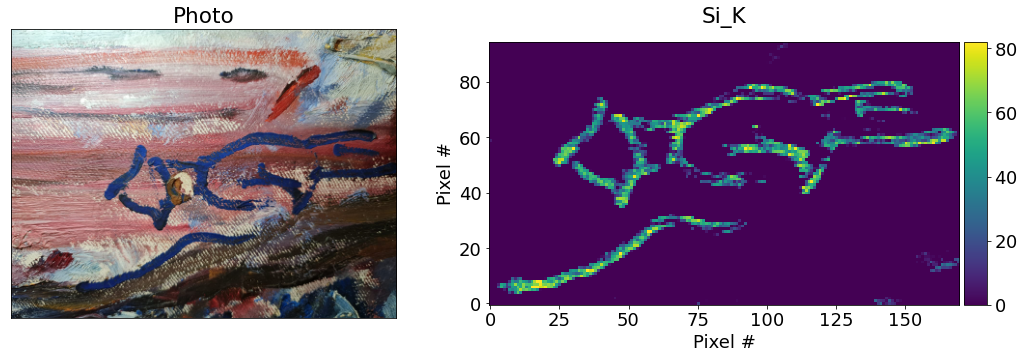

In [17]:
%matplotlib inline
#%matplotlib qt
rcParams['font.size'] = 18

element_chosen = 'Si'

for i, label in enumerate(data_xrf.metadata['labels']):
    #if element_chosen in label:   # search for the given string in XRF label
    if element_chosen + '_' in label:   # search for the given string + '_' in XRF label
        fig, axs = subplots(1, 2, figsize = (15, 5))
        fig.tight_layout(w_pad = 0)

        ax = axs[0]
        filename_photo = glob(path_photo + '*.jpg')[0]
        im = Image.open(filename_photo).transpose(1)
        ax.imshow(im.reduce(4))
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_title('Photo')
        
        ax = axs[1]
        im = ax.imshow(data_xrf.labels[..., i], interpolation = 'none', vmin = 0, vmax = None)
        formatter = ScalarFormatter(useMathText = True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-2, 2))
        cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.01, 0, 0.05, 1]), format = formatter)
        cb.ax.yaxis.set_offset_position('left')
        ax.set_xlabel('Pixel #')
        ax.set_ylabel('Pixel #')
        ax.set_title(label, y = 1.05)

show()

### Plot RGB from 3 XRF maps

Pb:	Pb_L
Hg:	Hg_L
Si:	Si_K


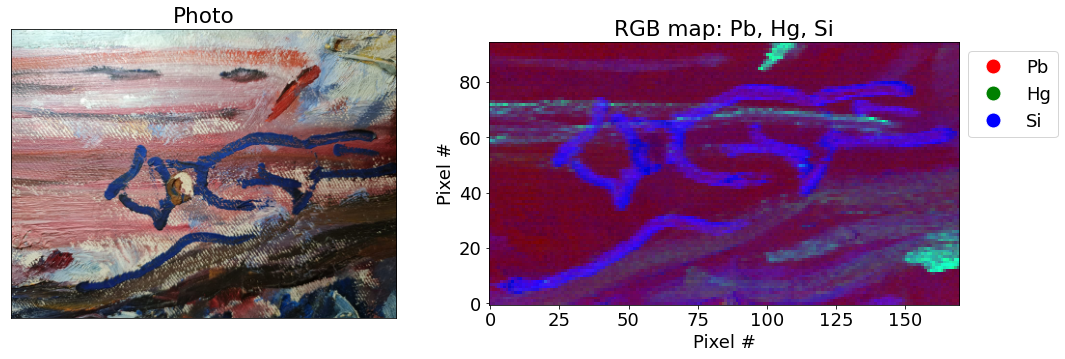

In [18]:
rcParams['font.size'] = 18
elements_chosen = ['Pb', 'Hg', 'Si']
factors_intensity = [0.5, 1, 1]

check_find = [False] * 3
image_rgb = empty(list(data_xrf.labels.shape[:2]) + [3])
for i, elem in enumerate(elements_chosen):
    j = find_element(elem, data_xrf.metadata['labels'])
    if j is None:
        print(elem + ' not found.')
    else:
        print(elem + ':\t' + data_xrf.metadata['labels'][j])
        check_find[i] = True
        image_rgb[..., i] = data_xrf.labels[..., j]

if all(check_find):
    image_rgb -= image_rgb.min(axis = (0, 1), keepdims = True)
    image_rgb /= image_rgb.max(axis = (0, 1), keepdims = True)
    image_rgb *= array(factors_intensity)[newaxis, newaxis, :]
    #image_rgb /= image_rgb.max()
    image_rgb = clip(image_rgb, 0, 1)

    fig, axs = subplots(1, 2, figsize = (15, 5))
    fig.tight_layout(w_pad = 0)

    ax = axs[0]
    filename_photo = glob(path_photo + '*.jpg')[0]
    im = Image.open(filename_photo).transpose(1)
    ax.imshow(im.reduce(4))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title('Photo')
        
    ax = axs[1]
    im = ax.imshow(image_rgb, interpolation = 'none')
    legend_elements = [
        Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = c, markersize = 15, label = elements_chosen[i])
            for i, c in enumerate(['r', 'g', 'b'])
    ]
    ax.legend(handles = legend_elements, bbox_to_anchor = (1, 1), loc = 'upper left')
    ax.set_xlabel('Pixel #')
    ax.set_ylabel('Pixel #')
    ax.set_title('RGB map: ' + ', '.join(elements_chosen))

    show()

extent = ax.get_tightbbox(fig.canvas.renderer).expanded(1.05, 1.05).transformed(fig.dpi_scale_trans.inverted())
fig.savefig(path_figures + 'RGB_' + '_'.join(elements_chosen) + '.png', bbox_inches = extent)

### Check phases in a given point
- `phases_calibration`: the cell will calibrate the experimental XRD pattern on the mix of these phases
- `phase_compare`: the diffraction lines of this phases will be shown for comparison

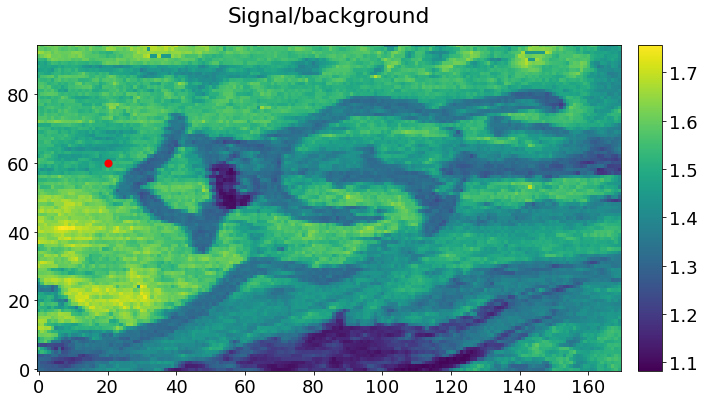

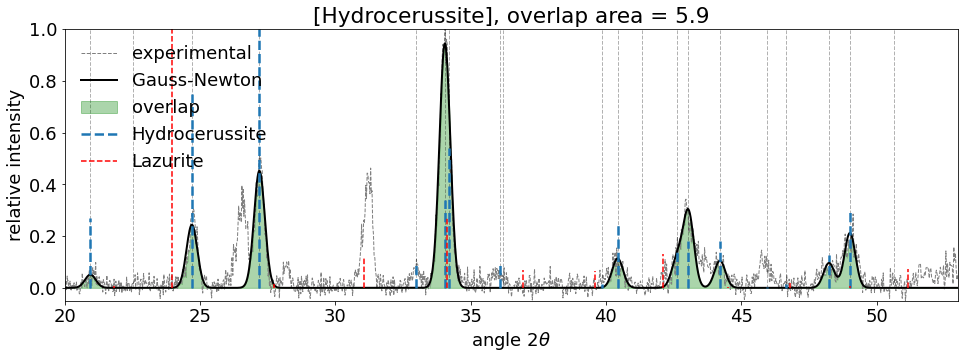

In [19]:
%matplotlib inline
rcParams['font.size'] = 18

x, y = 20, 60

phases_calibration = PhaseList([hydrocerussite])
phase_compare = lazurite

fig, ax = subplots(figsize = (15, 6))
im = ax.imshow(data.signal_background_ratio.squeeze(), interpolation = 'none')
#im = ax.imshow(presence_phases_sel[1], interpolation = 'none')
ax.scatter(x, y, s = 50, c = 'red', marker = 'o')
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
ax.set_title('Signal/background', y = 1.05)

gn = GaussNewton(phases_calibration, FastSpectraXRD().from_Data(data, x, y), min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)

### Leaves initial calibration and only optimizes the heights of the peaks ###
#gn.fit_cycle(gamma = True, steps = 16)

### Optimizes calibration and heights of the peaks ###
gn.fit_cycle(gamma = True, steps = 16).fit_cycle(a = True, s = True, gamma = True, steps = 16).fit_cycle(gamma = True, steps = 16)

fig, ax = subplots(figsize = (16, 5))
sca(ax)
gn.plot_spectrum(c = 'grey', ls = '--', lw = 1, label = 'experimental')
gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
gn.phase.plot(color = 'k', lw = 1, lineheight = 1, alpha = 0.3, label = '')
gn.phase.plot(lw = 2.5, alpha = 1)
phase_compare.plot()
ax.set_xlim(min_theta, max_theta)
ax.set_ylim(-0.05, 1)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel(r'relative intensity')
ax.set_title(f'{gn.label}, overlap area = {gn.overlap3_area():.1f}')
legend(frameon = False, loc = 2)
show()

# Search for primary phases

### Adjust initial calibration
This can be executed after the first fit finds a better initial calibration.

In [20]:
if 'pmax_a' in locals():
    data.opt[0] = pmax_a
    data.opt[1] = pmax_s
#data.opt = array([-1208.08149362, 1948.24846333, 51.66346438])
opt_initial = data.opt.copy()

### Create data structure

In [21]:
phases_primary = [hydrocerussite, lazurite, cinnabar]

In [22]:
gm = GammaMap().from_data(data, phases_primary, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks)

### Autocalibration and search
Optimizes on $a,s$ and $\gamma$. Choses the best phase by overlap area and fits with respect to that.

In [23]:
%%time
gm = gm.search()
L1loss, MSEloss, overlap_area = gm.metrics()

Using 8 CPUs
Using 8 CPUs
CPU times: user 11.6 s, sys: 1.83 s, total: 13.5 s
Wall time: 19.3 s


### Fast mapping

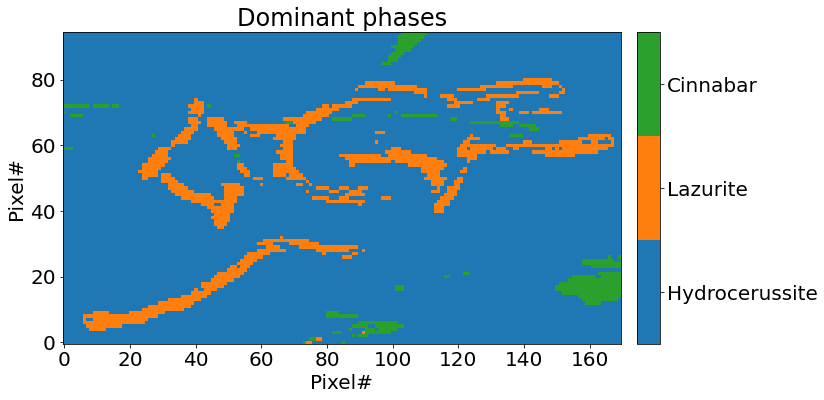

In [24]:
%matplotlib inline
rcParams['font.size'] = 20

fig, ax = subplots(figsize = (10, 6))
cmap_chosen = get_cmap('tab10')
norm_chosen = BoundaryNorm(arange(-0.5, len(phases_primary) + 0.5, 1), len(phases_primary))
im = imshow(gm.selected(), cmap = cmap_chosen, norm = norm_chosen, interpolation = 'none')
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_ticks(range(0, len(phases_primary)))
cbar.set_ticklabels([p.label for p in phases_primary])
ax.set_title('Dominant phases')
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')

savefig(path_figures + 'fast_map_dominant_phases.png', bbox_inches = 'tight', dpi = 200)
show()

### Histogram of $a$

If $a$ is spead over too large area it means that fitting went wrong. Maybe we need to add phases.

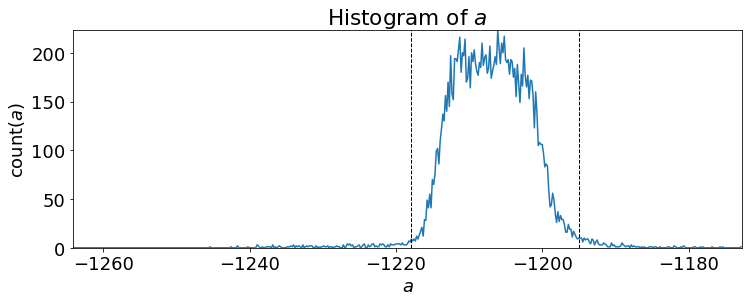

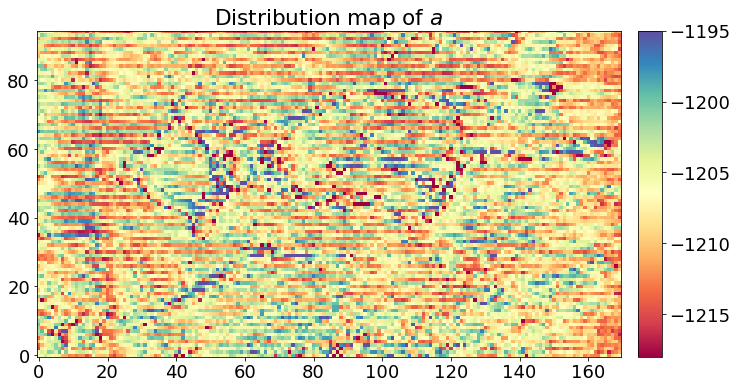

In [25]:
%matplotlib inline
rcParams['font.size'] = 18

opt = gm.opt()
a = opt[..., 0]
s = opt[..., 1]

### Set them for better representation of color map ###
vmin = -1218
vmax = -1195

h, b = histogram(a, bins = 512)

fig, ax = subplots(figsize = (12, 4))
ax.plot(b[:-1], h)
ax.set_xlim(b[0], b[-1])
#ax.set_xlim(-1230, -1180) # TO CHANGE HORIZONTAL SCALE: set these value, otherwise leave this line commented
ax.set_ylim(0, h.max())
ax.vlines(vmin, 0, h.max(), 'k', ls = '--', lw = 1)
ax.vlines(vmax, 0, h.max(), 'k', ls = '--', lw = 1)
ax.set_xlabel('$a$')
ax.set_ylabel(r'count($a$)')
ax.set_title(r'Histogram of $a$')
savefig(path_figures + f'histogram_a_ROI({vmin},{vmax}).png')

fig, ax = subplots(figsize = (12, 6))
ax.set_title('Distribution map of $a$')
im = ax.imshow(a, cmap = 'Spectral', interpolation = 'none', vmin = vmin, vmax = vmax)
colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
savefig(path_figures + f'distribution_map_a_ROI({vmin},{vmax}).png')

show()

## Plotting the $a,s$ dependence

There is a slight notion of a second $a, s$ dependence but it is weak.

Linear: [ -1.64617054 -39.05707599]
Cauchy: [ -0.91130629 847.18166458]
mean a,s: -1206.9420662396833 1947.7753997248687
most probable a,s: -1206.0991421880037 1946.3073942273668


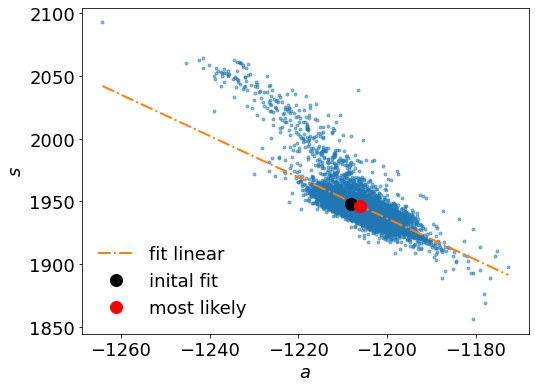

In [26]:
%matplotlib inline
rcParams['font.size'] = 18

opt, var = curve_fit(f_linear, a.flatten(), s.flatten())
res = least_squares(f_loss, x0 = opt, args = (a.flatten(), s.flatten()), loss = 'cauchy')
pmax_a = b[h.argmax()]
pmax_s = f_linear(pmax_a, *res['x'])
x = linspace(a.min(), a.max(), 10)
# linear_y = f_linear(a.flatten(), *opt)
# cauchy_y = f_linear(a.flatten(), *res['x'])

print('Linear:', opt)
print('Cauchy:', res['x'])
print('mean a,s:', a.mean(), s.mean())
print('most probable a,s:', pmax_a, pmax_s)

fig, ax = subplots(figsize = (8, 6))
ax.plot(a.flatten(), s.flatten(), '.', alpha = 0.5)
ax.plot(x, f_linear(x, *opt), '-.', lw = 2, label = 'fit linear')
#ax.plot(x, f_linear(x, *res['x']), '--', lw = 2, label = 'fit cauchy')
ax.plot(data.opt[0], data.opt[1], 'ko', ms = 12, label = 'inital fit')
ax.plot(pmax_a, pmax_s, 'ro', ms = 12, label = 'most likely')
ax.legend(frameon = False)
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$s$')

### TO SET HORIZONTAL AND VERTICAL SCALE ###
# If you prefer automatic scale, you can leave this options commented.
#ax.set_xlim(-1250, -1180)
#ax.set_ylim(1850, 2000)

savefig(path_figures + 'fit_a_s.png')
show()

### Quantify phase presence

In [27]:
correction = data.rescaling**0.5
#correction = data.signal_background_ratio

criterion = overlap_area * correction

Hydrocerussite: Pb
Lazurite: Si
Cinnabar: Hg, S


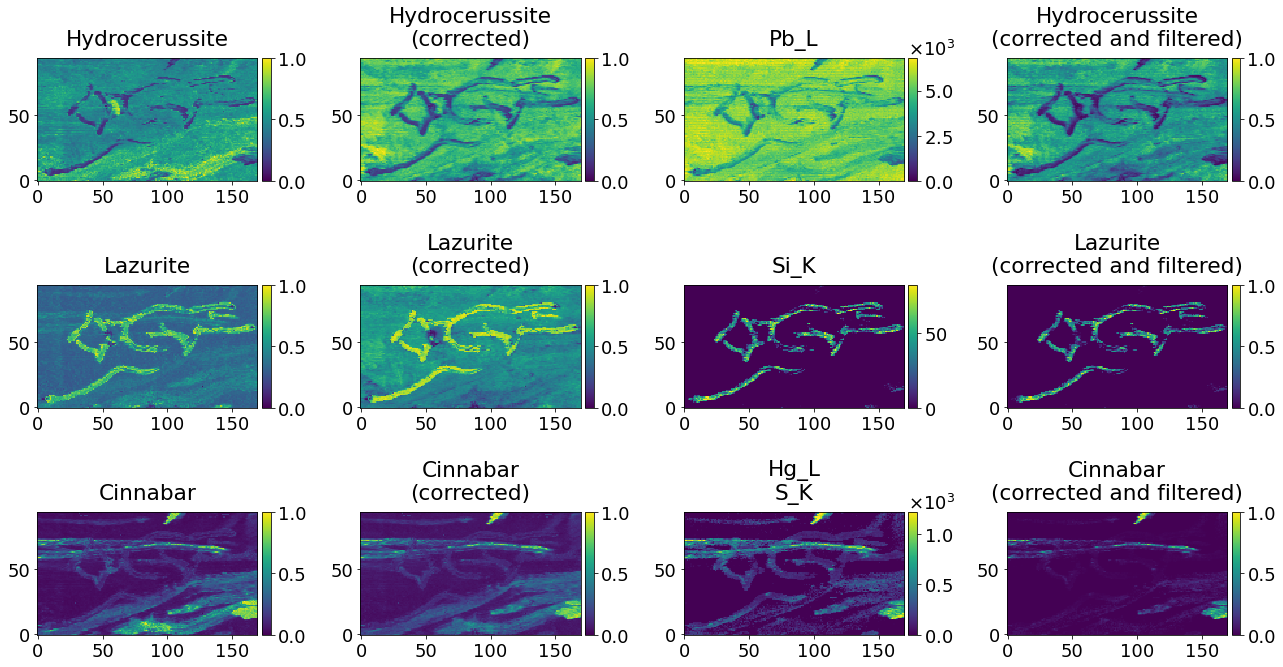

In [28]:
%matplotlib inline
rcParams['font.size'] = 18
position_colorbar = [1.02, 0, 0.04, 1]

fig, axs = subplots(len(gm.phases), 4, figsize = (18, 3 * len(gm.phases)))
fig.tight_layout(h_pad = 4, w_pad = 2)

for i, phase in enumerate(gm.phases):
    if (len(gm.phases) > 1):
        ax = axs[i, 0]
    else:
        ax = axs[0]
    matrix_plot = overlap_area[..., i].copy()
    matrix_plot /= matrix_plot.max()
    im = ax.imshow(matrix_plot, interpolation = 'none', vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes(position_colorbar))
    ax.set_title(phase.label, y = 1.05)
    
    if (len(gm.phases) > 1):
        ax = axs[i, 1]
    else:
        ax = axs[1]
    matrix_plot = criterion[..., i].copy()
    matrix_plot /= matrix_plot.max()
    im = ax.imshow(matrix_plot, interpolation = 'none', vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes(position_colorbar))
    ax.set_title(phase.label + '\n(corrected)', y = 1.05)
    
    print(phase.label + ': ' + ', '.join(phase['associated elements']))
    indices_associated_elements = []
    for element in phase['associated elements']:
        j = find_element(element, data_xrf.metadata['labels'], allow_loose = False)
        if j is None:
            print(phase.label + ': ' + phase['associated element'] + ' not found')
        else:
            indices_associated_elements.append(j)
    if indices_associated_elements:        
        
        if (len(gm.phases) > 1):
            ax = axs[i, 2]
        else:
            ax = axs[2]
        map_xrf = data_xrf.labels[..., indices_associated_elements].min(axis = -1)
        im = ax.imshow(map_xrf, interpolation = 'none', vmin = 0, vmax = None)
        formatter = ScalarFormatter(useMathText = True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-2, 2))
        cb = colorbar(im, ax = ax, cax = ax.inset_axes(position_colorbar), format = formatter)
        cb.ax.yaxis.set_offset_position('left')
        ax.set_title('\n'.join([data_xrf.metadata['labels'][idx] for idx in indices_associated_elements]), y = 1.05)
        
        if (len(gm.phases) > 1):
            ax = axs[i, 3]
        else:
            ax = axs[3]
        map_xrd = criterion[..., i] / criterion[..., i].max()
        map_xrf = map_xrf / map_xrf.max()
        map_xrd_corrected = map_xrd * map_xrf
        map_xrd_corrected /= map_xrd_corrected.max()
        im = ax.imshow(map_xrd_corrected, interpolation = 'none', vmin = 0)
        colorbar(im, ax = ax, cax = ax.inset_axes(position_colorbar))
        ax.set_title(phase.label + '\n(corrected and filtered)', y = 1.05)

show()

# Select the phase to analyse

In [29]:
phase_sel = cinnabar

### Calibrate on it

In [30]:
%%time

print(f'Calibrating on {phase_sel.label}...')
gm_sel = GammaMap().from_data(data, [phase_sel], sigma = sigma, min_theta = min_theta, max_theta = max_theta, 
                             min_intensity = min_intensity, first_n_peaks = first_n_peaks)
gm_sel = gm_sel.search(phase_selected = 0)
print('Done.')

Calibrating on Cinnabar...
Using 8 CPUs
Done.
CPU times: user 5.36 s, sys: 2.12 s, total: 7.49 s
Wall time: 8.72 s


In [31]:
idx = gm.phases.index(phase_sel)
presence_phase_sel = criterion[..., idx] / criterion[..., idx].max()

# Analyse the selected phase in a given area

### Select area

Area: 170 * 95 = 16150


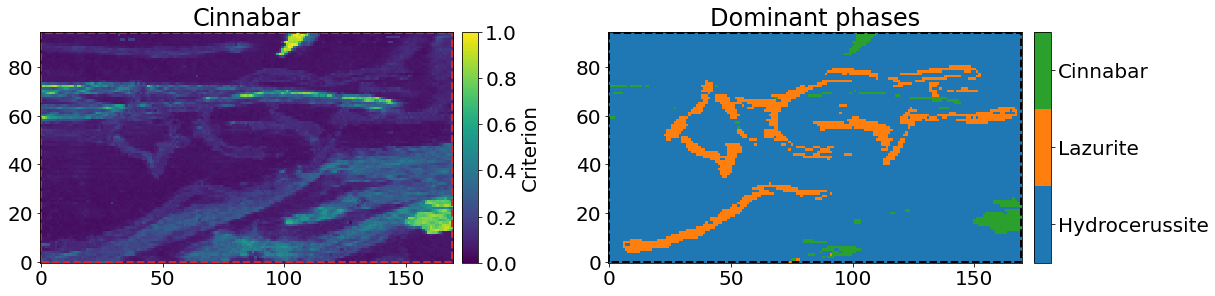

In [32]:
%matplotlib inline
rcParams['font.size'] = 20
position_colorbar = [1.02, 0, 0.04, 1]

# All scanned area
x_min, x_max = 0, data.shape[1] - 1
y_min, y_max = 0, data.shape[0] - 1

# Selected area
#x_min, x_max = 0, 139
#y_min, y_max = 0, 125

area_sel = (x_max - x_min + 1) * (y_max - y_min + 1)
print(f'Area: {x_max - x_min + 1} * {y_max - y_min + 1} = {area_sel}')

fig, axs = subplots(1, 2, figsize = (15, 5))
fig.tight_layout(w_pad = 5)

ax = axs[0]
im = ax.imshow(presence_phase_sel, interpolation = 'none', vmin = 0, vmax = 1)
settings_plot(im, ax, None, None, None, None, position_colorbar, 'Criterion')
ax.plot(
    [x_min, x_min, x_max, x_max, x_min],
    [y_min, y_max, y_max, y_min, y_min],
    ls = '--', c = 'tab:red', lw = 2
)
ax.set_title(phase_sel.label)

ax = axs[1]
cmap_chosen = get_cmap('tab10')
norm_chosen = BoundaryNorm(arange(-0.5, len(gm.phases) + 0.5, 1), len(gm.phases))
im = imshow(gm.selected(), cmap = cmap_chosen, norm = norm_chosen, interpolation = 'none')
ax.plot(
    [x_min, x_min, x_max, x_max, x_min],
    [y_min, y_max, y_max, y_min, y_min],
    ls = '--', c = 'black', lw = 2
)
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_ticks(range(0, len(gm.phases)))
cbar.set_ticklabels([p.label for p in gm.phases])
ax.set_title('Dominant phases')

savefig(f'{path_figures + phase_sel.label}__selected_area.png', bbox_inches = 'tight', dpi = 200)
show()

### Select conditions

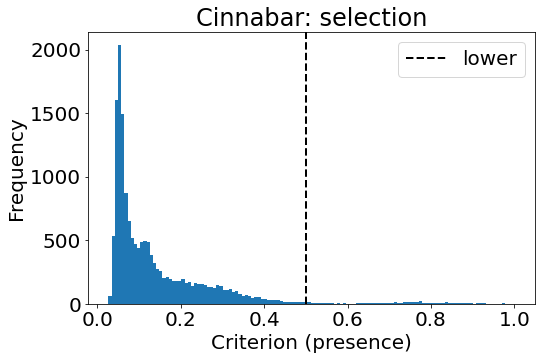

These thresholds select 400 pixels.


In [34]:
%matplotlib inline
rcParams['font.size'] = 20

threshold = {'low': 0.5, 'high': None}

indices_area = zeros(data.shape[:2], bool)
indices_good = zeros(data.shape[:2], bool)
for x in range(data.shape[1]):
    for y in range(data.shape[0]):
        if ((x >= x_min) and (x <= x_max) and (y >= y_min) and (y <= y_max)):
            indices_area[y, x] = True
            if ( ((threshold['low'] is None) or (presence_phase_sel[y, x] >= threshold['low']))  and
                ((threshold['high'] is None) or (presence_phase_sel[y, x] <= threshold['high']))
            ):
                indices_good[y, x] = True

calibration_sel_a = gm_sel.opt()[..., 0].copy()
calibration_sel_s = gm_sel.opt()[..., 1].copy()
calibration_a_diff = calibration_sel_a - opt_initial[0]
calibration_s_diff = calibration_sel_s - opt_initial[1]

calibration_sel_a[~indices_good] = None
calibration_sel_s[~indices_good] = None
calibration_a_diff[~indices_good] = None
calibration_s_diff[~indices_good] = None

a_diff_max = nanmax(absolute(calibration_a_diff))
a_diff_min = - a_diff_max
s_diff_max = nanmax(absolute(calibration_s_diff))
s_diff_min = - s_diff_max

fig, ax = subplots(figsize = (8, 5))
ax.hist(presence_phase_sel[indices_area].flatten(), bins = 'sqrt') # 'sqrt' 'doane'
if (threshold['low'] is not None):
    ax.axvline(threshold['low'], c = 'black', ls = '--', lw = 2, label = 'lower')
if (threshold['high'] is not None):
    ax.axvline(threshold['high'], c = 'black', ls = '-', lw = 2, label = 'upper')
if (threshold['low'] is not None or threshold[i]['high'] is not None):
    ax.legend(loc = 'upper right')
ax.set_xlabel('Criterion (presence)')
ax.set_ylabel('Frequency')
ax.set_title(f'{phase_sel.label}: selection')

savefig(f'{path_figures + phase_sel.label}__selection.png', bbox_inches = 'tight', dpi = 300)
show()
print(f'These thresholds select {indices_good.sum()} pixels.')

### Distribution of `a` in selected pixels

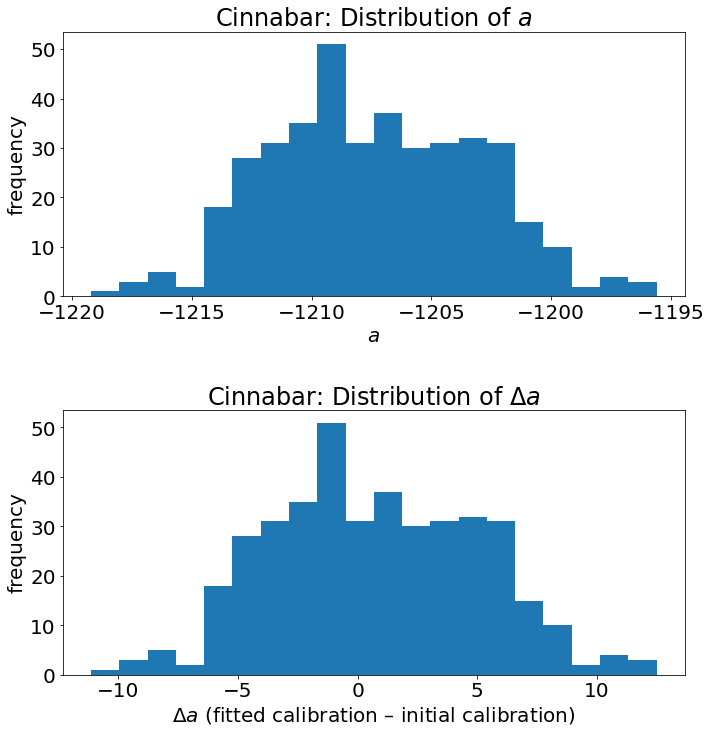

In [35]:
%matplotlib inline
rcParams['font.size'] = 20

fig, axs = subplots(2, 1, figsize = (10, 10))
fig.tight_layout(h_pad = 4)

ax = axs[0]
ax.hist(calibration_sel_a.flatten(), bins = 'sqrt') # 'sqrt' 'doane'
ax.set_xlabel(f'$a$')
ax.set_ylabel('frequency')
ax.set_title(f'{phase_sel.label}: Distribution of $a$')

ax = axs[1]
ax.hist(calibration_a_diff.flatten(), bins = 'sqrt') # 'sqrt' 'doane'
ax.set_xlabel(f'$\Delta a$ (fitted calibration – initial calibration)')
ax.set_ylabel('frequency')
ax.set_title(f'{phase_sel.label}: Distribution of $\Delta a$')

savefig(f'{path_figures + phase_sel.label}__histogram_a_in_selection.png', bbox_inches = 'tight', dpi = 300)
show()

### Exploration of the area

/var/folders/t4/2fp3yd4127g0hx04c52d4fgm0000gn/T/ipykernel_25981/262775371.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  cmap_seismic.set_bad(color = 'grey')


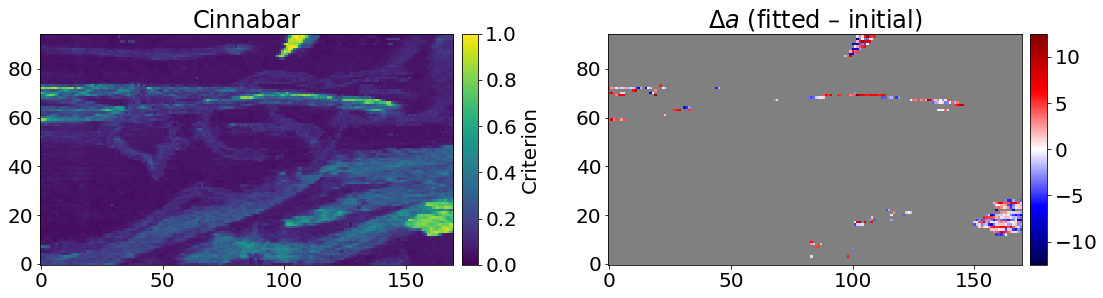

In [191]:
%matplotlib inline
rcParams['font.size'] = 20
position_colorbar = [1.02, 0, 0.04, 1]

cmap_seismic = get_cmap('seismic')#.copy()
cmap_seismic.set_bad(color = 'grey')

fig, axs = subplots(1, 2, figsize = (15, 8))
fig.tight_layout(w_pad = 5)

ax = axs[0]
im = ax.imshow(presence_phase_sel, interpolation = 'none', vmin = 0, vmax = 1)
settings_plot(im, ax, x_min, x_max, y_min, y_max, position_colorbar, 'Criterion')
ax.set_title(phase_sel.label)

ax = axs[1]
im = ax.imshow(calibration_a_diff, interpolation = 'none', vmin = a_diff_min, vmax = a_diff_max, cmap = cmap_seismic)
settings_plot(im, ax, x_min, x_max, y_min, y_max, position_colorbar, powerlimits = (-2, 2))
ax.set_title(f'$\Delta a$ (fitted – initial)')

savefig(f'{path_figures + phase_sel.label}__exploration_of_area.png', bbox_inches = 'tight', dpi = 300)
show()

### Check a point

/var/folders/t4/2fp3yd4127g0hx04c52d4fgm0000gn/T/ipykernel_25981/3838747677.py:11: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  cmap_seismic.set_bad(color = 'grey')


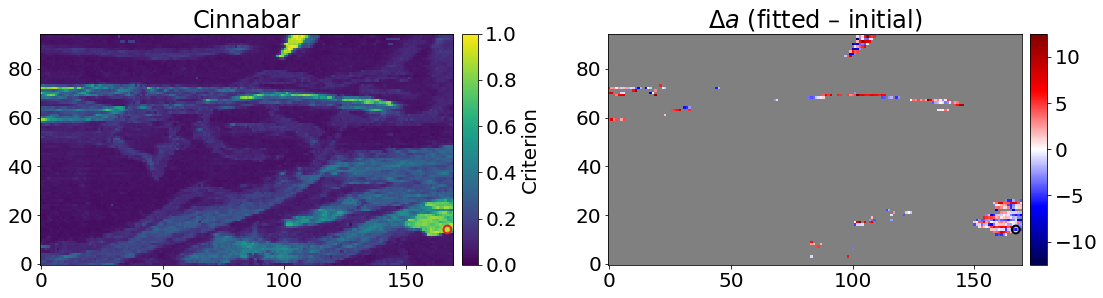

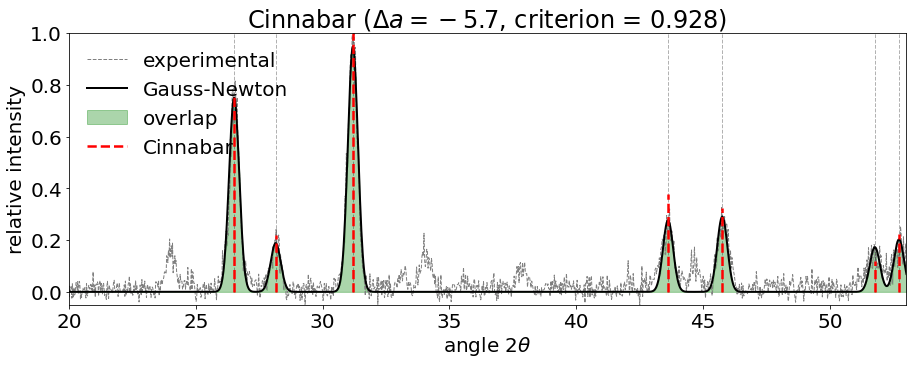

In [204]:
%matplotlib inline
rcParams['font.size'] = 20
position_colorbar = [1.02, 0, 0.04, 1]

#x, y = 167, 14 # high criterion, low a, right zone
#x, y = 163, 15 # high criterion, high a, right zone
#x, y = 102, 69


cmap_seismic = get_cmap('seismic')#.copy()
cmap_seismic.set_bad(color = 'grey')

fig, axs = subplots(1, 2, figsize = (15, 8))
fig.tight_layout(w_pad = 5)

ax = axs[0]
im = ax.imshow(presence_phase_sel, interpolation = 'none', vmin = 0, vmax = 1)
ax.scatter(x, y, s = 60, lw = 2, marker = 'o', edgecolors = 'tab:red', facecolors = 'none')
settings_plot(im, ax, x_min, x_max, y_min, y_max, position_colorbar, 'Criterion')
ax.set_title(phase_sel.label)

ax = axs[1]
im = ax.imshow(calibration_a_diff, interpolation = 'none', vmin = a_diff_min, vmax = a_diff_max, cmap = cmap_seismic)
ax.scatter(x, y, s = 60, lw = 2, marker = 'o', edgecolors = 'black', facecolors = 'none')
settings_plot(im, ax, x_min, x_max, y_min, y_max, position_colorbar, powerlimits = (-2, 2))
ax.set_title(f'$\Delta a$ (fitted – initial)')

show()

fig, ax = subplots(figsize = (15, 5))
sca(ax)
gn = gm_sel.get_pixel(x, y)[0]
gn.plot_spectrum(c = 'grey', ls = '--', lw = 1, label = 'experimental')
gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
gn.phase.plot(color = 'k', lw = 1, lineheight = 1, alpha = 0.3, label = '',
             min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)
gn.phase.plot(lw = 2.5, alpha = 1,
             min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)
ax.set_xlim(min_theta, max_theta)
ax.set_ylim(-0.05, 1)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel(r'relative intensity')
ax.set_title(f'{gn.label} ($\Delta a = {calibration_a_diff[y, x]:.1f}$, criterion = {presence_phase_sel[y, x]:.3f})')
legend(frameon = False, loc = 2)

savefig(f'{path_figures + phase_sel.label}__pixel_{x}_{y}.png', bbox_inches = 'tight', dpi = 300)
show()